# Twitter Sentiment Analysis

In [1]:
!pip install gensim
!pip install keras
!pip install pandas

You are using pip version 18.1, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow import keras

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Settings

In [4]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [5]:
dataset_filename = os.listdir("../input")[0]
dataset_path = os.path.join("..","input",dataset_filename)
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: ../input/training.1600000.processed.noemoticon.csv


In [6]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [7]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [8]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [9]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 1.05 s, sys: 45.2 ms, total: 1.09 s
Wall time: 1.09 s


Text(0.5,1,'Dataset labels distribuition')

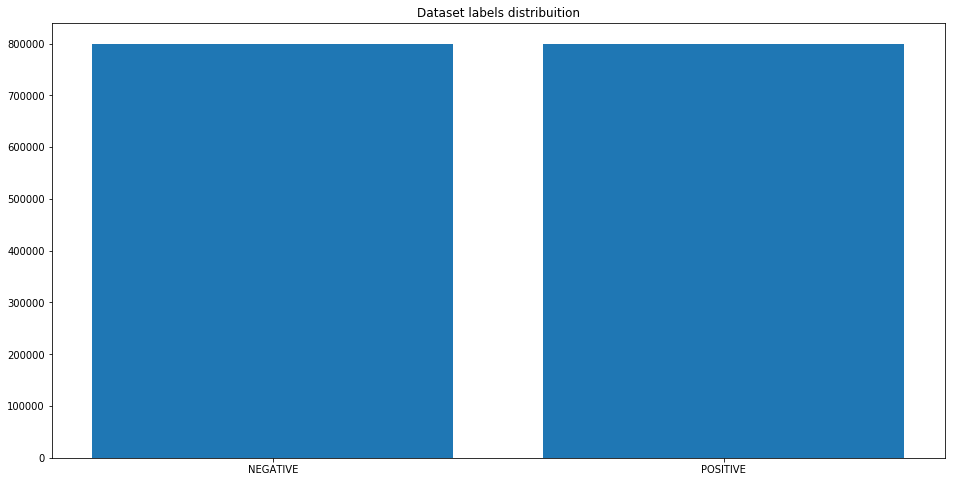

In [10]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [11]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [12]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [13]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 1min 8s, sys: 225 ms, total: 1min 8s
Wall time: 1min 8s


### Split train and test

In [14]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec 

In [15]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 3.19 s, sys: 330 ms, total: 3.52 s
Wall time: 3.52 s


In [16]:
# w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
#                                             window=W2V_WINDOW, 
#                                             min_count=W2V_MIN_COUNT, 
#                                             workers=8)

In [ ]:
# w2v_model.build_vocab(documents)

In [18]:
# words = w2v_model.wv.vocab.keys()
# vocab_size = len(words)
# print("Vocab size", vocab_size)

Vocab size 30369


In [19]:
# %%time
# w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2023-09-06 14:28:13,094 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2023-09-06 14:28:14,111 : INFO : EPOCH 1 - PROGRESS: at 4.13% examples, 336709 words/s, in_qsize 14, out_qsize 0
2023-09-06 14:28:15,125 : INFO : EPOCH 1 - PROGRESS: at 8.58% examples, 348330 words/s, in_qsize 14, out_qsize 2
2023-09-06 14:28:16,161 : INFO : EPOCH 1 - PROGRESS: at 13.25% examples, 355595 words/s, in_qsize 14, out_qsize 0
2023-09-06 14:28:17,204 : INFO : EPOCH 1 - PROGRESS: at 17.35% examples, 348922 words/s, in_qsize 16, out_qsize 5
2023-09-06 14:28:18,237 : INFO : EPOCH 1 - PROGRESS: at 22.43% examples, 359294 words/s, in_qsize 13, out_qsize 2
2023-09-06 14:28:19,255 : INFO : EPOCH 1 - PROGRESS: at 27.21% examples, 363559 words/s, in_qsize 16, out_qsize 0
2023-09-06 14:28:20,322 : INFO : EPOCH 1 - PROGRESS: at 31.65% examples, 360430 words/s, in_qsize 15, out_qsize 0
2023-09-06 14:28:21,379 : INFO : EPOCH 1 - PROGRESS: a

CPU times: user 21min 56s, sys: 6.53 s, total: 22min 3s
Wall time: 11min 51s


(263128559, 295270528)

In [20]:
# w2v_model.most_similar("love")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2023-09-06 14:40:04,831 : INFO : precomputing L2-norms of word weight vectors
/opt/conda/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('luv', 0.5728189945220947),
 ('loves', 0.5529061555862427),
 ('loved', 0.5282349586486816),
 ('adore', 0.5161417126655579),
 ('amazing', 0.5116719603538513),
 ('looove', 0.4981512427330017),
 ('awesome', 0.4757436215877533),
 ('loveee', 0.4593009352684021),
 ('lovee', 0.4527668356895447),
 ('loooove', 0.43235740065574646)]

### Tokenize Text

In [21]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 28.4 s, sys: 175 ms, total: 28.6 s
Wall time: 28.6 s


In [22]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 45.4 s, sys: 1.05 s, total: 46.5 s
Wall time: 46.6 s


### Label Encoder 

In [23]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [24]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [25]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [26]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### Embedding layer

In [27]:
# embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
# for word, i in tokenizer.word_index.items():
#   if word in w2v_model.wv:
#     embedding_matrix[i] = w2v_model.wv[word]
# print(embedding_matrix.shape)

(290419, 300)


In [28]:
# embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [29]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


### Compile model

In [30]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [31]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [32]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/8
1152000/1152000 [==============================] - 549s 476us/step - loss: 0.5058 - acc: 0.7494 - val_loss: 0.4659 - val_acc: 0.7795
Epoch 2/8
1152000/1152000 [==============================] - 549s 477us/step - loss: 0.4802 - acc: 0.7665 - val_loss: 0.4593 - val_acc: 0.7830
Epoch 3/8
1152000/1152000 [==============================] - 549s 477us/step - loss: 0.4729 - acc: 0.7715 - val_loss: 0.4540 - val_acc: 0.7864
Epoch 4/8
1152000/1152000 [==============================] - 551s 478us/step - loss: 0.4705 - acc: 0.7727 - val_loss: 0.4525 - val_acc: 0.7868
Epoch 5/8
1152000/1152000 [==============================] - 553s 480us/step - loss: 0.4677 - acc: 0.7745 - val_loss: 0.4497 - val_acc: 0.7884
Epoch 6/8
1152000/1152000 [==============================] - 550s 477us/step - loss: 0.4663 - acc: 0.7755 - val_loss: 0.4493 - val_acc: 0.7883
Epoch 7/8
1152000/1152000 [==============================] - 546s 474us/step - loss: 0.46

### Save model

In [ ]:
model.save(KERAS_MODEL)
# w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

### Evaluate

In [33]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

320000/320000 [==============================] - 55s 173us/step

ACCURACY: 0.790184375
LOSS: 0.44764613780975343
CPU times: user 1min 16s, sys: 5.38 s, total: 1min 22s
Wall time: 55.3 s


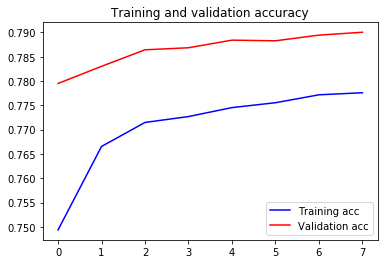

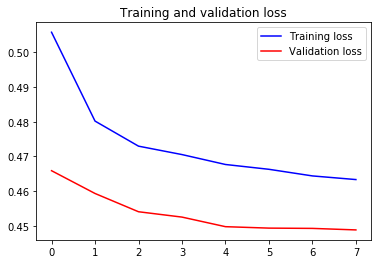

In [34]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [35]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [36]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [37]:
predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.9634526968002319,
 'elapsed_time': 0.3146176338195801}

In [38]:
predict("I hate the rain")

{'label': 'NEGATIVE',
 'score': 0.007147940341383219,
 'elapsed_time': 0.152601957321167}

In [39]:
predict("i don't know what i'm doing")

{'label': 'NEGATIVE',
 'score': 0.3178417682647705,
 'elapsed_time': 0.1657118797302246}

In [48]:
predict("my goverment is best goverment of world")

{'label': 'POSITIVE',
 'score': 0.9096284508705139,
 'elapsed_time': 0.1488020420074463}

In [49]:
predict("Hindus are taking over mosques")

{'label': 'NEUTRAL',
 'score': 0.5497072339057922,
 'elapsed_time': 0.15550708770751953}

In [51]:
predict("india's name would be changed to bharat very soon")

{'label': 'POSITIVE',
 'score': 0.7107789516448975,
 'elapsed_time': 0.15281128883361816}

In [52]:
predict("Jai shree ram")

{'label': 'NEUTRAL',
 'score': 0.498546838760376,
 'elapsed_time': 0.22453641891479492}

In [59]:
predict("NEW DELHI: The RJD, along with other opposition parties, has questioned the use of President of Bharat instead of the customary President of India in the G20 dinner invite. However, an old video is doing the rounds which shows RJD chief Lalu Prasad speaking about the dichotomy between Bharat and India. The video, which is in circulation on microblogging site X - formerly known as Twitter, shows vintage Lalu Prasad using Neem twig to clean his teeth. Interacting with the interviewer, the RJD chief says he uses toothbrush when he is in Delhi as it is difficult to get a neem twig in the national capital. And then in his inimitable style he adds: Delhi is India, this is Bharat.Lalu's remark seems to highlight the perceived contrast between India and Bharat which has been often brought to the fore by several leaders over the years. Several leaders supporting the governments move feel use of India is a colonial hangover and should be done away with. They claim that the word Bharat is a true reflection of the country. The use of President of Bharat on the G20 invite triggered speculations about the possibility of government debating formal name change in the special Parliament session. When asked about these reports, Union minister Rajeev Chandrasekhar had yesterday said wait and watch. Opposition parties claim that the Modi government and the BJP have stopped using the name India as they are scared of their new alliance which is also called INDIA (Indian National Developmental Inclusive Alliance). Lalu's son and Bihar deputy chief minister Tejashwi Yadav has claimed that Prime Minister Modi is “scared” of the opposition coalition 'INDIA' and is the reason why his government shunned the word while referring to the country. He said the ruling BJP should rethink their preference for Bharat, used in a G20 dinner invite, since the multi-party opposition has also adopted 'Badhe")

{'label': 'NEUTRAL',
 'score': 0.5961993336677551,
 'elapsed_time': 0.1506950855255127}

In [60]:
predict("The minister in the letter to the commerce ministry had requested for allocation of four SEZ including those in Bodh Gaya, Fatuha, Muzaffarpur and Bhagalpur, Bihar industries minister Samir Kumar Mahaseth he has sent a letter to the Centre for allocating at least four SEZs. (Twitter | Samir Kumar Mahaseth) , Bihar industries minister Samir Kumar Mahaseth has requested the Union commerce ministry to allocate at least four special economic zones (SEZs) in Bihar paving the way for fresh investment opportunities, Talking to the media persons in Madhubani, the minister said that he has sent a letter to the central government for allocating at least four SEZs in Bihar to help the state become a new investment destination., “Entrepreneurs are looking up towards Bihar with a lot of hope after the announcement of new policies for textile, leather and other sectors. However, creation of the SEZ would simply give an extra boost to the industries department’s bid to make the state next investment destination,” said the minister.")

{'label': 'POSITIVE',
 'score': 0.7435713410377502,
 'elapsed_time': 0.15360021591186523}

In [61]:
predict("Indian Railways have earmarked Nilgiri Mountain Railways on metre guage and Darjeeling Himalayan Railways on narrow guage for promotion of heritage tourism by steam locomotive. During the year-long celebrations of 150 glorious years of railways in India, steam loco hauled trains were run on Mumbai-Thane, Shimla-Kathleeghat, Bolarm-Monoharabad and Howrah-Bandel sections by reviving steam locomotives. At present, 33 steam locomotives are working on Indian Railways.")

{'label': 'NEUTRAL',
 'score': 0.6479485630989075,
 'elapsed_time': 0.14968156814575195}

### Confusion Matrix

In [40]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

320000/320000 [==============================] - 21s 65us/step
CPU times: user 12.9 s, sys: 1.35 s, total: 14.3 s
Wall time: 21.7 s


In [41]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

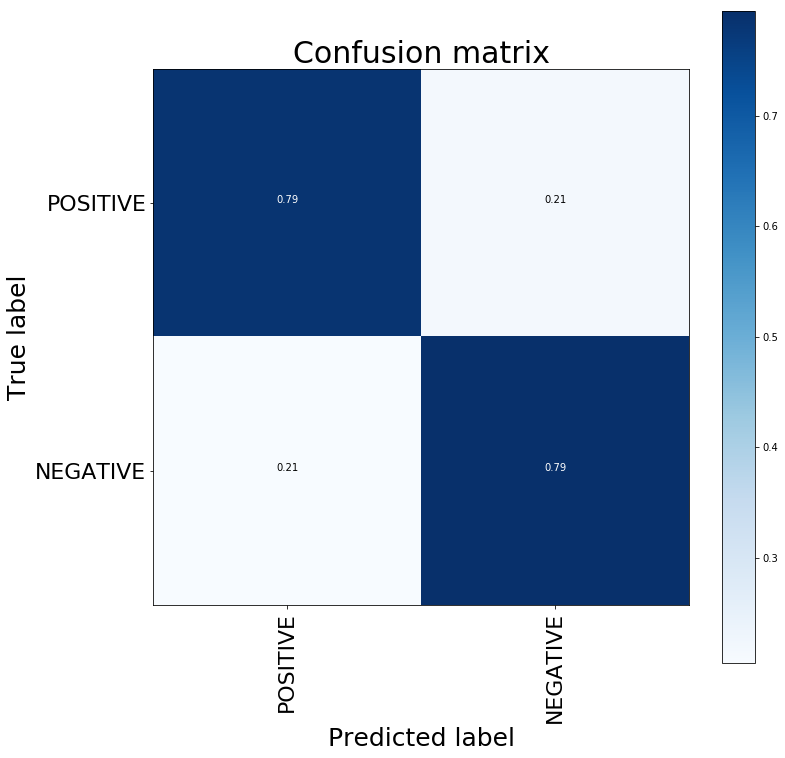

CPU times: user 1.82 s, sys: 248 ms, total: 2.06 s
Wall time: 1.72 s


In [42]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [43]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.79      0.79    159494
    POSITIVE       0.79      0.79      0.79    160506

   micro avg       0.79      0.79      0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



### Accuracy Score

In [44]:
accuracy_score(y_test_1d, y_pred_1d)

0.790184375